In [150]:
# standard library imports
import re
import pickle

# third-party library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# custom imports
from pprint import pprint
from sklearn.impute import KNNImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from category_encoders.one_hot import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from statistics import mean

In [152]:
dataset = pd.read_csv("../data/data_enriched.csv")

In [153]:
dataset.head()

,car_color,fuel_type,car_type,car_license,gear_type,windows,motor_power,speedometer,passengers_number,payment_method,car_state,ex_owners,additions,price
0,أبيض عاجي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,2000,75000,5.0,نقدا فقط,للبيع فقط,1.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,100000
1,سكني,ديزل,خصوصي,فلسطينية,نصف اوتوماتيك,الكتروني,2500,130000,8.0,إمكانية التقسيط,للبيع أو التبديل,2.0,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,60000
2,سكني,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1600,NaN,NaN,نقدا فقط,للبيع فقط,NaN,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nمسجل CD\n...,43500
3,بيج,بنزين,خصوصي,فلسطينية,عادي,يدوي,906,NaN,5.0,إمكانية التقسيط,للبيع فقط,0.0,\n\nمُكيّف\nمسجل CD\n\n,5500
4,فضي,بنزين,خصوصي,فلسطينية,اوتوماتيك,الكتروني,1200,38000,5.0,نقدا فقط,للبيع فقط,NaN,\n\nمُكيّف\nإغلاق مركزي\nجهاز إنذار\nجنطات مغن...,54000


In [154]:
dataset.shape

(6864, 14)

## Feature Engineering

### Handle outliers

In [288]:
type(dataset['speedometer'])

pandas.core.series.Series

In [159]:
def handle_outliers(data, feature):
    """handle outliers

    Args:
        data (DataFrame): dataset
        feature (Series): feature with outliers needed to be handled

    Returns:
        DataFrame: dataset after removing outliers
    """
    upper_lim = data[feature].quantile(.999)
    lower_lim = data[feature].quantile(.0000001)

    return data[(data[feature] < upper_lim) & (data[feature] > lower_lim)]

In [ ]:
dataset = handle_outliers(dataset, 'speedometer')

In [142]:
dataset.shape

(6864, 14)

### Handle missing data

In [ ]:
def get_list_columns_names_with_missing_values(data):
    """ get list of columns names (headers) that detected having missing values

    Args:
        data (DataFrame): dataset

    Returns:
        List: list of columns names (headers) that detected having missing values
    """
    return data.columns[data.isna().any()].tolist()

In [156]:
def handle_missing_data(data):
    """handle missing data using KNNImputer

    Args:
        data (DataFrame): dataset
    """
    nan_columns = get_list_columns_names_with_missing_values(data)
    if nan_columns:
        model = KNNImputer(n_neighbors=3)
        after_imputation = model.fit_transform(data[nan_columns])
        for indx, feature in enumerate(nan_columns):
            data[feature] = after_imputation[:,indx].round().astype(int)


In [157]:
handle_missing_data(dataset)

#### Feature Selection

In [160]:
dataset.drop(['additions'], axis=1, inplace=True) 

#### Define models to train/test the data on

In [85]:
models = {'ols': {'model': LinearRegression(), 
                  'description': 'orinary least square'
                  },
        'sgd1': {'model': SGDRegressor(),
                  'description': 'gradient descent with 1000 iteration'
                  },
        'sgd2': {'model': SGDRegressor(max_iter=10),
                  'description': 'gradient descent with 10 iteration'
                  },
        'ply2': {'model': LinearRegression(),
                  'degree': 2,
                  'description': 'Polynomial with 2 degree'
                  },
        'ply2_ridge': {'model': Ridge(),
                  'degree': 2,
                  'description': 'orinary least square'
                  },
        'ply2_lasso': {'model': Lasso(),
                  'degree': 2,
                  'description': 'orinary least square'
                  },
        '3nn': {'model': KNeighborsClassifier(n_neighbors=3),
                  'description': 'KNN with k=3'
                  },
        'DT': {'model': DecisionTreeRegressor(),
                  'description': 'Decision Tree Regressor'
                  },
        "rfr": {"model": RandomForestRegressor(n_estimators = 15),
                  "description":"Random Forest Regressor"
                  },
        'GBR': {'model': GradientBoostingRegressor(),
                  'description': 'Gradient Boosting Regressor'
                  }
  }

#### Define funcitons needed to train, predict, and evaluate the data

In [75]:
def train_plynomial_model(model, degree, X_train, y_train):
    """train polynomial model with the given degree

    Args:
        model (sklearn model): model to fit polynomial degree on to become a polynomial model
        degree (int): degree of polynomial model
        X_train (ndarray): features
        y_train (ndarray): target variable
    """
    poly = PolynomialFeatures(degree)
    poly_x_train = poly.fit_transform(X_train)
    model.fit(poly_x_train, y_train)

In [76]:
def train_model(models, X_train, y_train):
    """ train models by fitting each model on training dataset

    Args:
        models (Dict): dictionary of models to be evaluated
        X_train (ndarray): features
        y_train (ndarray): target variable

    Returns:
        Dict: models dictionary adjusted after fitting each model with training data
    """
    # go over all models
    for model_id in models:
        # train if polynomial
        print(models[model_id])
        if models[model_id].get("degree"):
            train_plynomial_model(models[model_id]['model'],\
                                  models[model_id]['degree'],\
                                  X_train,\
                                  y_train)
            
        else:  
            models[model_id]['model'].fit(X_train, y_train)
        #print(models[model_id]['model'].coef_)
        #print(models[model_id]['model'].intercept_)
        
    # return the new dictionary
    return models

In [77]:
def predict_plynomial_model(model, degree, X_test):
    """ predict polynomial model with specific degree

    Args:
        model (sklearn model): model to fit polynomial degree on to become a polynomial model
        degree (int): degree of polynomial model
        X_test (ndarray): features

    Returns:
        ndarray: polynomial predicted values for X_test data
    """
    poly = PolynomialFeatures(degree)
    poly_x_test = poly.fit_transform(X_test)   
    return model.predict(poly_x_test)

In [86]:
def eval_models(models, X_test, y_test, train_test):
    """ Evaluate the data despite it's training set or test set using r2 and RMSE evaluation metrics 
    and add the score for each model to the dictionary

    Args:
        models (Dict): dictionary of models to be evaluated
        X_test (ndarray): features
        y_test (ndarray): target variable
        train_test (str): whether the data is a training set or testing set

    Returns:
        Dict: models dictionary adjusted with added evaluation score
    """
    # go over all models
    for model_id in models:
        # predict them
        if models[model_id].get("degree"): #if not (models[model_id].get("degree") is None):
            y_predict= predict_plynomial_model(models[model_id]['model'],\
                                  models[model_id]['degree'],\
                                  X_test)
            
        else: 
            y_predict = models[model_id]['model'].predict(X_test)

        # evaluate models using 'RMSE' evaluation metric
        rmse = mean_squared_error(y_test, y_predict, squared=False) # np.sqrt(mean_squared_error())

        if train_test == 'train':
            models[model_id]["train_RMSE"] = rmse
            
            # evaluate models using 'R square' evaluation metric
            models[model_id]["train_R2_score"] = r2_score(y_test, y_predict)
        
        else:
            models[model_id]["test_RMSE"] = rmse
            
            # evaluate models using 'R square' evaluation metric
            models[model_id]["test_R2_score"] = r2_score(y_test, y_predict)

    # return models dictionary adjusted attached with evaluation metric
    return models

#### Split data into features and target variable

In [ ]:
X = dataset.drop(columns = 'price')
y = dataset['price'] 

In [ ]:
# get categorical features
categorical_features = dataset.select_dtypes(['object']).columns.to_list()

In [ ]:
# get numeric features
numeric_features = X.select_dtypes('number').columns.to_list()

#### Feature Preprocessing Transformation
###### transform features applying ColumnTransformer() pipeline

In [ ]:
# Apply different preprocessing steps to different columns of the data
transformer = ColumnTransformer(
    transformers = [  
        # encode categorical features using OneHotEncoder()
        ('categorical', OneHotEncoder(), categorical_features),
        # feature scaling on numeric features using log transformation
        ('numerical', PowerTransformer(), numeric_features),
    ],
    remainder='passthrough'
    )

In [ ]:
# transform the features
X_transformed = transformer.fit_transform(X)

c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-predictio

Split the data

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
                            X_transformed, y,
                            test_size=.25, random_state=42
                            )

In [ ]:
y_train.shape

(5148,)

In [ ]:
y_test.shape

(1716,)

In [88]:
train_model(models, X_train, y_train)

{'model': LinearRegression(), 'description': 'orinary least square'}
{'model': SGDRegressor(), 'description': 'gradient descent with 1000 iteration'}
{'model': SGDRegressor(max_iter=10), 'description': 'gradient descent with 10 iteration'}
{'model': LinearRegression(), 'degree': 2, 'description': 'Polynomial with 2 degree'}


c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


{'model': Ridge(), 'degree': 2, 'description': 'orinary least square'}
{'model': Lasso(), 'degree': 2, 'description': 'orinary least square'}


c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.476e+12, tolerance: 1.674e+09
  model = cd_fast.enet_coordinate_descent(


{'model': KNeighborsClassifier(n_neighbors=3), 'description': 'KNN with k=3'}
{'model': DecisionTreeRegressor(), 'description': 'Decision Tree Regressor'}
{'model': RandomForestRegressor(n_estimators=15), 'description': 'Random Forest Regressor'}
{'model': GradientBoostingRegressor(), 'description': 'Gradient Boosting Regressor'}


In [91]:
eval_models(models, X_test, y_test, 'test')

In [94]:
eval_models(models, X_train, y_train, 'train')

In [99]:
# Observe scores in a neat way
pd.DataFrame.from_dict(models,orient='index')

,model,description,test_RMSE,test_R2_score,train_RMSE,train_R2_score,degree
ols,LinearRegression(),orinary least square,4.904144e+04,2.596994e-01,49003.404843,0.261542,NaN
sgd1,SGDRegressor(),gradient descent with 1000 iteration,4.896399e+04,2.620358e-01,49055.157190,0.259982,NaN
sgd2,SGDRegressor(max_iter=10),gradient descent with 10 iteration,4.893300e+04,2.629696e-01,49212.814200,0.255217,NaN
ply2,LinearRegression(),Polynomial with 2 degree,9.348140e+12,-2.689875e+16,45166.412707,0.372658,2.0
ply2_ridge,Ridge(),orinary least square,4.901041e+04,2.606358e-01,45325.005570,0.368245,2.0
ply2_lasso,Lasso(),orinary least square,4.970858e+04,2.394207e-01,45191.688533,0.371956,2.0
3nn,KNeighborsClassifier(n_neighbors=3),KNN with k=3,5.585759e+04,3.961339e-02,51336.139662,0.189563,NaN
DT,DecisionTreeRegressor(),Decision Tree Regressor,6.899300e+04,-4.651825e-01,5544.078355,0.990548,NaN
rfr,"(DecisionTreeRegressor(max_features=1.0, rando...",Random Forest Regressor,4.983191e+04,2.356421e-01,21599.493423,0.856530,NaN
GBR,([DecisionTreeRegressor(criterion='friedman_ms...,Gradient Boosting Regressor,4.709193e+04,3.173868e-01,42773.852571,0.437361,NaN


In [122]:
def models_evaluation_test_train(models):
    """Present Model name, R2 train score, and R2 test score for each model neatly

    Args:
        models (Dict): dictionary of models trained and evaluated, along with 
                a description for each model and its train score and test score
    """
    for model in models:
        print(model)
        print(f"train_R2_score = {models[model]['train_R2_score']}")
        print(f"test_R2_score = {models[model]['test_R2_score']}")
        print('-----------------------------------------------')
        

In [123]:
models_evaluation_test_train(models)

ols
train_R2_score = 0.261542333398054
test_R2_score = 0.25969942320951633
-----------------------------------------------
sgd1
train_R2_score = 0.25998174397307183
test_R2_score = 0.2620357747626767
-----------------------------------------------
sgd2
train_R2_score = 0.25521745203901636
test_R2_score = 0.26296955630947916
-----------------------------------------------
ply2
train_R2_score = 0.37265811067963694
test_R2_score = -2.6898751741365708e+16
-----------------------------------------------
ply2_ridge
train_R2_score = 0.3682448038262921
test_R2_score = 0.2606357748093837
-----------------------------------------------
ply2_lasso
train_R2_score = 0.3719557736839182
test_R2_score = 0.23942069792260268
-----------------------------------------------
3nn
train_R2_score = 0.1895625413876112
test_R2_score = 0.03961338651088231
-----------------------------------------------
DT
train_R2_score = 0.990547823784261
test_R2_score = -0.46518252610868105
------------------------------------

* GradientBoostingRegressor() scored the highest. Then tune its hyperparameters to get better score

### Hyper Parameter Tuning

##### Show GradientBoostingRegressor() parameters to choose which to tune 

In [201]:
gradient_boosting = GradientBoostingRegressor(random_state=42)
gradient_boosting.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'squared_error',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

#### Define the Grid for GBT
##### Set up the parameter distribution for the random search

In [220]:
# Number of trees in Gradient Boosting Trees 
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 74, num = 10)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5, 10, 16]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 7]
# Method of selecting samples for training each tree
learning_rate = [0.01, 0.1]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'learning_rate': learning_rate}
pprint(random_grid)

{'learning_rate': [0.01, 0.1],
 'max_depth': [5, 12, 20, 28, 35, 43, 51, 58, 66, 74, None],
 'min_samples_leaf': [2, 4, 7],
 'min_samples_split': [5, 10, 16],
 'n_estimators': [100, 200, 300, 400, 500]}


#### Create the random search object with desired options for best hyperparameters

* 5 fold cross validation
* Search across 10 different combinations
* Use all available cores
* R Squared evaluation metric

In [222]:
gbt_random_search = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(), # the base model
    param_distributions=random_grid, # grid of hyper parameters
    n_iter=10,  # Number of parameter combinations to try
    cv=5,  # Number of folds for cross-validation
    scoring='r2',  # Evaluation metric
    verbose=2,  # print some logs while evaluating the different combinations
    random_state=42,  # Random seed for reproducibility
    n_jobs = 1 # use all cores in the machine to train (parallel)
)

##### Fit the random search object to the training data

In [223]:
gbt_random_search.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END learning_rate=0.01, max_depth=35, min_samples_leaf=7, min_samples_split=5, n_estimators=400; total time=   8.7s
[CV] END learning_rate=0.01, max_depth=35, min_samples_leaf=7, min_samples_split=5, n_estimators=400; total time=   8.2s
[CV] END learning_rate=0.01, max_depth=35, min_samples_leaf=7, min_samples_split=5, n_estimators=400; total time=   8.0s
[CV] END learning_rate=0.01, max_depth=35, min_samples_leaf=7, min_samples_split=5, n_estimators=400; total time=   8.1s
[CV] END learning_rate=0.01, max_depth=35, min_samples_leaf=7, min_samples_split=5, n_estimators=400; total time=   8.2s
[CV] END learning_rate=0.01, max_depth=58, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   3.7s
[CV] END learning_rate=0.01, max_depth=58, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   3.6s
[CV] END learning_rate=0.01, max_depth=58, min_samples_leaf=4, min_samples_split=5, n_estima

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=1,
                   param_distributions={'learning_rate': [0.01, 0.1],
                                        'max_depth': [5, 12, 20, 28, 35, 43, 51,
                                                      58, 66, 74, None],
                                        'min_samples_leaf': [2, 4, 7],
                                        'min_samples_split': [5, 10, 16],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500]},
                   random_state=42, scoring='r2', verbose=2)

In [225]:
# Get the best hyperparameters from the search
gbt_best_params = gbt_random_search.best_params_
gbt_best_params

{'n_estimators': 100,
 'min_samples_split': 16,
 'min_samples_leaf': 7,
 'max_depth': 5,
 'learning_rate': 0.1}

In [226]:
# Get the best score from the random search
gbt_random_search.best_score_

0.3415376529703741

In [289]:
cross_validation_scores = {}

In [290]:
cross_validation_scores['Best score for RandomSearch on GradientBoostingRegressor() model = '] = gbt_random_search.best_score_

#### Get the model with the best hyper parameters and observe its score

In [227]:
best_gbt_model = gbt_random_search.best_estimator_
best_gbt_model

GradientBoostingRegressor(max_depth=5, min_samples_leaf=7, min_samples_split=16)

In [228]:
best_gbt_model.score(X_test, y_test)

0.31315937181750797

* gbt_random_search scored higher than best_gbt_model

In [292]:
cross_validation_scores['test score for {best_estimator_} resulted from RandomSearch on GradientBoostingRegressor() model = '] = best_gbt_model.score(X_test, y_test)

In [293]:
cross_validation_scores

{'Best score for RandomSearch on GradientBoostingRegressor() model = ': 0.30951744511893564,
 'test score for {best_estimator_} resulted from RandomSearch on GradientBoostingRegressor() model = ': 0.31315937181750797}

#### Use the best hyperparameters to create a new model to make predictions

In [251]:
best_model_gbt = GradientBoostingRegressor(**gbt_best_params)

#### Create model pipeline to utilize it in microservice for prediction

In [252]:
pipeline = Pipeline(
    steps = [
        ("transformer", transformer),
        ("model", best_model_gbt)
    ]
)

In [239]:
# fit the pipeline on the all the dataset
pipeline.fit(X, y) 

c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-prediction\venv_car_price_pred\lib\site-packages\category_encoders\one_hot.py:145: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for cat_name, class_ in values.iteritems():
c:\Users\DELL\Study\ML2 2022\ML2 Assignment1 Car Price Prediction\car-price-predictio

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical',
                                                  OneHotEncoder(),
                                                  ['car_color', 'fuel_type',
                                                   'car_type', 'car_license',
                                                   'gear_type', 'windows',
                                                   'payment_method',
                                                   'car_state']),
                                                 ('numerical',
                                                  PowerTransformer(),
                                                  ['motor_power', 'speedometer',
                                                   'passengers_number',
                                                   'ex_owners'])])),
                ('model',
                 GradientBoostingRegressor(max_depth=5, min_samples_leaf=7,
                                           min_samples_split=16))])

In [241]:
pickle.dump(pipeline,
            open('../pkls/best_model_gbt_random_search.pkl',
            'wb'))

### Cross Validation

##### Cross Validaiton on GradientBoostingRegressor() with best hyperparameters resulted from Random Search hyperparameters tuning

In [ ]:
scores_best_model_gbt_cv = cross_val_score(best_model_gbt, X_transformed, y, cv=10, scoring='r2')

In [ ]:
print(scores_best_model_gbt_cv.mean())
print(scores_best_model_gbt_cv.max())

0.33665947277710984
0.4924454753398648


In [297]:
cross_validation_scores['mean score for Gradient Boosting with best hyperparameters resulted from Random Search = '] = scores_best_model_gbt_cv.mean()
cross_validation_scores['max score for Gradient Boosting with best hyperparameters resulted from Random Search = '] = scores_best_model_gbt_cv.max()

##### Cross Validaiton on base GradientBoostingRegressor() without choosing hyperparameters

In [242]:
base_gbt = GradientBoostingRegressor(random_state = 42)

In [244]:
# it will return the 10 testing r2 scores as a numpy array
scores_base_gbt = cross_val_score(base_gbt, X_transformed, y, cv=10, scoring='r2')

In [249]:
# use average as an estimate of out-of-sample score
print(scores_base_gbt.mean())
print(scores_base_gbt.max())

0.32575315389124043
0.49057323870988356


In [294]:
cross_validation_scores['mean score 10 folds cross validation Base Gradient Boosting without Hyperparameters = '] = scores_base_gbt.mean()
cross_validation_scores['max score 10 folds cross validation Base Gradient Boosting without Hyperparameters = '] = scores_base_gbt.max()

##### Cross Validaiton on GradientBoostingRegressor() with {n_estimators} hyperparameter

In [257]:
gbt_with_n_estimators = GradientBoostingRegressor(n_estimators = 10, random_state = 42)

In [258]:
# it will return the 10 testing r2 scores as a numpy array
scores_gbt_with_n_estimators = cross_val_score(gbt_with_n_estimators, X_transformed, y, cv=10, scoring='r2')

In [259]:
# use average accuracy as an estimate of out-of-sample accuracy
print(scores_gbt_with_n_estimators.mean())
print(scores_gbt_with_n_estimators.max())

0.20593386116484474
0.31236456900332066


In [301]:
cross_validation_scores['mean score 10 folds cross validation Base Gradient Boosting with 10 estimators hyperparameter = '] = scores_gbt_with_n_estimators.mean()
cross_validation_scores['max score 10 folds cross validation Base Gradient Boosting with 10 estimators hyperparameter = '] = scores_gbt_with_n_estimators.max()

#### Cross validation on different values of {n_estimators} hyperparameter

In [262]:
# Number of trees in Gradient Boosting Trees 
n_estimators = [int(x) for x in np.linspace(start = 100, stop = 500, num = 5)]
# empty list to store scores
n_scores = []

# 1. loop through reasonable values of n
for estimator in n_estimators:
    # 2. run GradientBoostingRegressor with n estimators
    gbt = GradientBoostingRegressor(n_estimators = estimator, random_state = 42)
    # 3. obtain cross_val_score for GradientBoostingRegressor with n estimators
    scores = cross_val_score(gbt, X_transformed, y, cv=10, scoring='r2')
    # 4. append mean of scores for n estimators to n_scores list
    n_scores.append(scores.mean())
    

print(n_scores)

[0.32575315389124043, 0.3228666231095151, 0.3192883249834837, 0.3124168543561406, 0.3003395619407253]


In [272]:
print('Highest score = ', max(n_scores))
print('Avg score = ', mean(n_scores))

Highest score =  0.32575315389124043
Avg score =  0.31613290365622104


In [300]:
cross_validation_scores['mean score 10 folds cross validation Gradient Boosting with 5 different values of mean cross validation for 5 different values of estimators hyperparameter = '] = mean(n_scores)
cross_validation_scores['max score 10 folds cross validation Gradient Boosting with 5 different values of mean cross validation for 5 different values of estimators hyperparameter = '] = max(n_scores)

Text(0, 0.5, 'Cross-validated score')

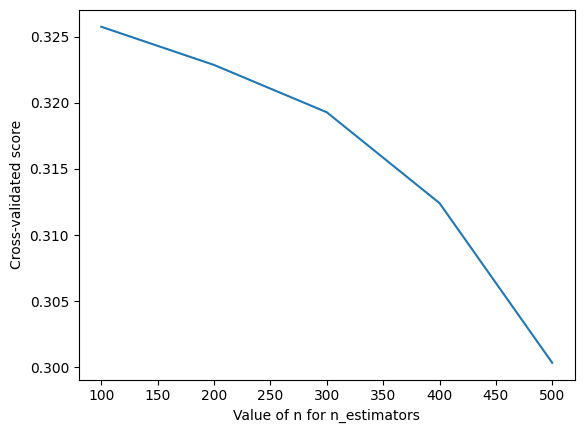

In [267]:
# plot how score changes as we vary {n}
# plot the value of n for n_estimators (x-axis) versus the cross-validated r2 score (y-axis)
plt.plot(n_estimators, n_scores)
plt.xlabel('Value of n for n_estimators')
plt.ylabel('Cross-validated score')

#### Cross Validation with another different values of n_estimators

In [273]:
# Number of trees in Gradient Boosting Trees 
n_estimators = [10,20,50,100,200,300,400]
# empty list to store scores
n_scores = []

# 1. loop through reasonable values of n
for estimator in n_estimators:
    # 2. run GradientBoostingRegressor with n estimators
    gbt = GradientBoostingRegressor(n_estimators = estimator, random_state = 42)
    # 3. obtain cross_val_score for GradientBoostingRegressor with n estimators
    scores = cross_val_score(gbt, X_transformed, y, cv=10, scoring='r2')
    # 4. append mean of scores for n estimators to n_scores list
    n_scores.append(scores.mean())
    

print(n_scores)

[0.20593386116484474, 0.2709339687182683, 0.3155739416070961, 0.32575315389124043, 0.3228666231095151, 0.3192883249834837, 0.3124168543561406]


In [274]:
print('Highest score = ', max(n_scores))
print('Avg score = ', mean(n_scores))

Highest score =  0.32575315389124043
Avg score =  0.296109532547227


In [303]:
cross_validation_scores['mean score 10 folds cross validation Gradient Boosting with 7 different values of mean cross validation for 7 different values of estimators hyperparameter = '] = mean(n_scores)
cross_validation_scores['max score 10 folds cross validation Gradient Boosting with 7 different values of mean cross validation for 7 different values of estimators hyperparameter = '] = max(n_scores)

Text(0, 0.5, 'Cross-validated score')

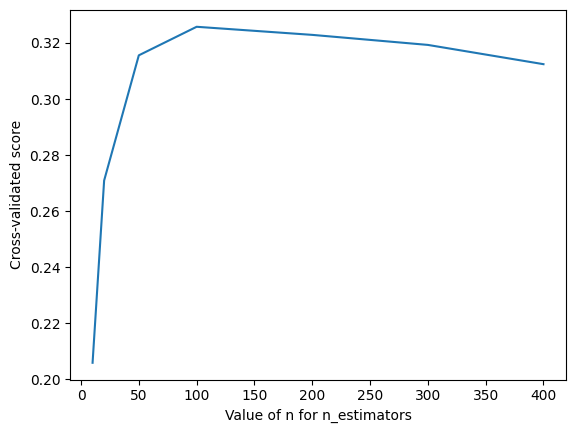

In [275]:
# plot how score changes as we vary {n}
# plot the value of n for n_estimators (x-axis) versus the cross-validated r2 score (y-axis)
plt.plot(n_estimators, n_scores)
plt.xlabel('Value of n for n_estimators')
plt.ylabel('Cross-validated score')

In [276]:
# maximum depth in Gradient Boosting Trees 
max_depth = [int(x) for x in np.linspace(5, 74, num = 10)]

# empty list to store scores
n_scores = []

# 1. loop through reasonable values of max_depth
for max_depth_tree in max_depth:
    # 2. run GradientBoostingRegressor with max_depth
    gbt = GradientBoostingRegressor(max_depth = max_depth_tree, random_state = 42)
    # 3. obtain cross_val_score for GradientBoostingRegressor with n estimators
    scores = cross_val_score(gbt, X_transformed, y, cv=10, scoring='r2')
    # 4. append mean of scores for n estimators to n_scores list
    n_scores.append(scores.mean())
    

print(n_scores)

[0.30185294078076075, 0.05647223615785464, -0.15147703536196405, -0.16042151370291052, -0.1674647554428482, -0.18844452563040964, -0.18844452563040964, -0.18844452563040964, -0.18844452563040964, -0.18844452563040964]


In [277]:
print('Highest score = ', max(n_scores))
print('Avg score = ', mean(n_scores))

Highest score =  0.30185294078076075
Avg score =  -0.10632607557211556


In [304]:
cross_validation_scores['mean score 10 folds cross validation Gradient Boosting with 10 different values of mean cross validation for 10 different values of max_depth hyperparameter = '] = mean(n_scores)
cross_validation_scores['max score 10 folds cross validation Gradient Boosting with 10 different values of mean cross validation for 10 different values of max_depth hyperparameter = '] = max(n_scores)

Text(0, 0.5, 'Cross-validated score')

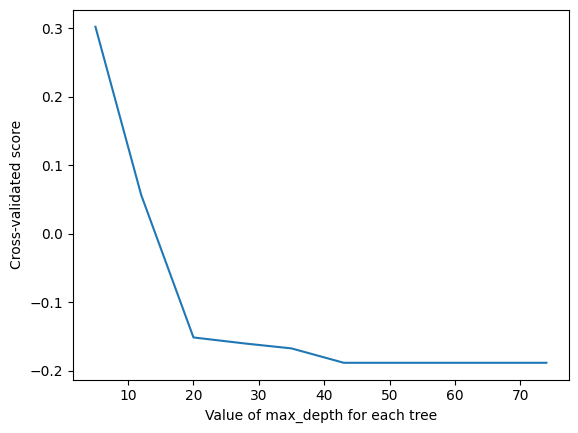

In [302]:
# plot how score changes as we vary {n}
# plot the value of n for n_estimators (x-axis) versus the cross-validated r2 score (y-axis)
plt.plot(max_depth, n_scores)
plt.xlabel('Value of max_depth for each tree')
plt.ylabel('Cross-validated score')

In [305]:
cross_validation_scores

{'Best score for RandomSearch on GradientBoostingRegressor() model = ': 0.30951744511893564,
 'test score for {best_estimator_} resulted from RandomSearch on GradientBoostingRegressor() model = ': 0.31315937181750797,
 'mean score 10 folds cross validation Base Gradient Boosting without Hyperparameters = ': 0.32575315389124043,
 'max score 10 folds cross validation Base Gradient Boosting without Hyperparameters = ': 0.49057323870988356,
 'mean score 10 folds cross validation Base Gradient Boosting with 10 estimators hyperparameter = ': 0.20593386116484474,
 'max score 10 folds cross validation Base Gradient Boosting with 10 estimators hyperparameter = ': 0.31236456900332066,
 'mean score for Gradient Boosting with best hyperparameters resulted from Random Search = ': 0.33665947277710984,
 'max score for Gradient Boosting with best hyperparameters resulted from Random Search = ': 0.4924454753398648,
 'mean score 10 folds cross validation Gradient Boosting with 5 different values of mean

In [310]:
for description, score in cross_validation_scores.items():
    print(score, '\t', description)


0.30951744511893564 	 Best score for RandomSearch on GradientBoostingRegressor() model = 
0.31315937181750797 	 test score for {best_estimator_} resulted from RandomSearch on GradientBoostingRegressor() model = 
0.32575315389124043 	 mean score 10 folds cross validation Base Gradient Boosting without Hyperparameters = 
0.49057323870988356 	 max score 10 folds cross validation Base Gradient Boosting without Hyperparameters = 
0.20593386116484474 	 mean score 10 folds cross validation Base Gradient Boosting with 10 estimators hyperparameter = 
0.31236456900332066 	 max score 10 folds cross validation Base Gradient Boosting with 10 estimators hyperparameter = 
0.33665947277710984 	 mean score for Gradient Boosting with best hyperparameters resulted from Random Search = 
0.4924454753398648 	 max score for Gradient Boosting with best hyperparameters resulted from Random Search = 
0.31613290365622104 	 mean score 10 folds cross validation Gradient Boosting with 5 different values of mean cro

* Observe that mean score of 10 different max_depth resulted in the lowest score
* Obeserve that mean score for Gradient Boosting with best hyperparameters resulted from Random Search is the highest